In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings 
warnings.filterwarnings("ignore")
from scipy.fftpack import fft
import math

In [2]:
def read_file(park,num):
    # read control data
    file=park[num]
    df = pd.read_csv(file, sep=";", header=None)
    df.columns = ["X", "Y", "Z", "Pressure","GripAngle", "Timestamp","TestID"]
    print("After reading file: ",df.head())
    return (df,file)

In [3]:
def get_plot(df):
    ax = df[df['TestID'] == 0].plot(x='X',y='Y',color='#2ca02c',alpha=0.5, figsize=(5,5))
    df[df['TestID'] == 1].plot(x='X',y='Y',ax=ax,color='#ff7f0e',alpha=0.5, figsize=(5,5))
    plt.ylim([0,450])
    plt.xlim([0,450])
    plt.legend(['Static','Dynamic'])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

    
    ax = df[df['TestID'] == 0].Pressure.plot(color='blue')
    df[df['TestID'] == 1].Pressure.plot(color='orange')
    plt.show()
    
    ax = df[df['TestID'] == 0].GripAngle.plot(color='blue')
    df[df['TestID'] == 1].GripAngle.plot(color='orange')
    plt.show()

In [4]:
def get_combined(df):
    df_static = df[df['TestID'] == 0].reset_index()
    df_dynamic = df[df['TestID'] == 1].reset_index()
    df_combined = df_static.merge(df_dynamic,how='inner',suffixes=['_S','_D'],left_index=True,right_index=True)
    df_combined=df_combined.drop('index_S',axis=1).drop('index_D',axis=1)
    return df_combined

In [5]:
def get_feature(data):
    data['dX_S'] = data['X_S'] - data['X_S'].shift(-1)
    data['dY_S'] = data['Y_S'] - data['Y_S'].shift(-1)
    a_s=data['dY_S']/data['dX_S']
    data['angle_S']=a_s.apply(lambda x: math.atan(x))
    data['angleChange_S']=data['angle_S'] - data['angle_S'].shift(-1)
    data['angleAccel_S']=data['angleChange_S'] - data['angleChange_S'].shift(-1)
    x_s = data['dX_S'] * data['dX_S']
    y_s = data['dY_S'] * data['dY_S']
    m_s = x_s + y_s
    data['PathLength_S'] = m_s.apply(lambda x: math.sqrt(x))
    data['accel_S']=data['PathLength_S'] - data['PathLength_S'].shift(-1)
    data['accel3_S']=data['accel_S'] - data['accel_S'].shift(-1)
    data['jerk_S']=data['accel3_S'] - data['accel3_S'].shift(-1)
    
    data['radX_S'] = data['X_S'] - data.iloc[0].X_S
    data['radY_S'] = data['Y_S'] - data.iloc[0].Y_S
    q_s=data['radY_S']/data['radX_S']
    # angle from 0 point
    # ang_s=theta
    data['ang_S']=q_s.apply(lambda x: math.atan(x))
    data['da_S']=data['ang_S']-data['ang_S'].shift(-1)
    
    a_s = data['radX_S'] * data['radX_S']
    b_s = data['radY_S'] * data['radY_S']
    c_s = a_s + b_s
    # rad_S=r
    data['rad_S'] = c_s.apply(lambda x: math.sqrt(x))
    data['dr/dt_S']=data['rad_S']-data['rad_S'].shift(-1)
    
    #######
    
    data['dX_D'] = data['X_D'] - data['X_D'].shift(-1)
    data['dY_D'] = data['Y_D'] - data['Y_D'].shift(-1)
    a_d=data['dY_D']/data['dX_D']
    data['angle_D']=a_d.apply(lambda x: math.atan(x))
    data['angleChange_D']=data['angle_D'] - data['angle_D'].shift(-1)
    data['angleAccel_D']=data['angleChange_D'] - data['angleChange_D'].shift(-1)
    
    x_d = data['dX_D'] * data['dX_D']
    y_d = data['dY_D'] * data['dY_D']
    m_d = x_d + y_d
    data['PathLength_D'] = m_d.apply(lambda x: math.sqrt(x))
    data['accel_D']=data['PathLength_D'] - data['PathLength_D'].shift(-1)
    data['accel3_D']=data['accel_D'] - data['accel_D'].shift(-1)
    data['jerk_D']=data['accel3_D'] - data['accel3_D'].shift(-1)
    
    data['radX_D'] = data['X_D'] - data.iloc[0].X_D
    data['radY_D'] = data['Y_D'] - data.iloc[0].Y_D
    q_d=data['radY_D']/data['radX_D']
    # angle from 0 point
    data['ang_D']=q_d.apply(lambda x: math.atan(x))
    data['da_D']=data['ang_D']-data['ang_D'].shift(-1)
    
    a_d = data['radX_D'] * data['radX_D']
    b_d = data['radY_D'] * data['radY_D']
    c_d = a_d + b_d
    data['rad_D'] = c_d.apply(lambda x: math.sqrt(x))
    data['dr/dt_D']=data['rad_D']-data['rad_D'].shift(-1)
    
    return (data)

In [6]:
def get_mean_var(df_combined):
    data_mean=[]
    data_var=[]
    for col in df_combined.columns:

        col_name_mean=col+'_Mean'
        data_mean.append(tuple([col_name_mean, df_combined[col].mean()]))

        col_name_var=col+'_Var'
        data_var.append(tuple([col_name_var, df_combined[col].var()]))

    data_mean = pd.DataFrame(data_mean).transpose()
    data_mean.columns = data_mean.iloc[0]
    data_mean = data_mean[1:]
    data_mean

    data_var = pd.DataFrame(data_var).transpose()
    data_var.columns = data_var.iloc[0]
    data_var = data_var[1:]
    data_var

    data=pd.concat([data_mean, data_var],axis=1)
    data['totalT_S']=max(df_combined['Timestamp_S'])-min(df_combined['Timestamp_S'])
    data['totalT_D']=max(df_combined['Timestamp_D'])-min(df_combined['Timestamp_D'])
    
    data['totalPath_S']=df_combined['PathLength_S'].sum()
    data['totalPath_D']=df_combined['PathLength_D'].sum()
    
    # Maximal radius
    data['RadMax_S']=max(df_combined['rad_S'])
    data['RadMax_D']=max(df_combined['rad_D'])
    
    # Maximal x,y difference and aspect ratio
    data['Xmax_S']=(max(df_combined['X_S'])-min(df_combined['X_S']))
    data['Ymax_S']=(max(df_combined['Y_S'])-min(df_combined['Y_S']))
    data['AR_S']=data['Ymax_S']/data['Xmax_S']
    
    data['Xmax_D']=(max(df_combined['X_D'])-min(df_combined['X_D']))
    data['Ymax_D']=(max(df_combined['Y_D'])-min(df_combined['Y_D']))
    data['AR_D']=data['Ymax_D']/data['Xmax_D']
    
    return data

In [7]:
def save(data,file):    
    file_save=file.replace(".txt",".csv")
    file_save=file_save.replace("data/raw/","")
    file_save="data/processed/"+file_save
    data.to_csv(file_save,index=False)

In [8]:
import glob
control_file=sorted(glob.glob("data/raw/control/*.txt"))
park_file=sorted(glob.glob("data/raw/parkinson/*.txt"))

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  201  200  0        20        880   68140147       0
1  201  200  0        86        900   68140154       0
2  201  200  0       123        900   68140161       0
3  201  200  0       146        900   68140168       0
4  201  200  0       158        900   68140175       0


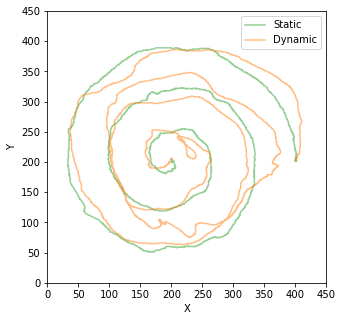

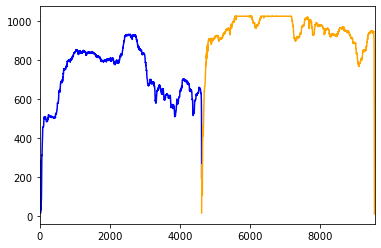

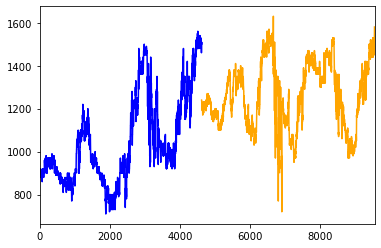

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  197  204  0         3       1470   69756397       0
1  196  204  0         9       1470   69756404       0
2  196  204  0        20       1450   69756411       0
3  196  204  0        33       1480   69756418       0
4  196  204  0        42       1470   69756425       0


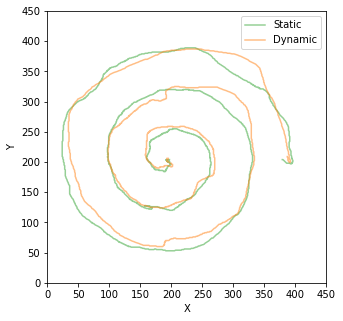

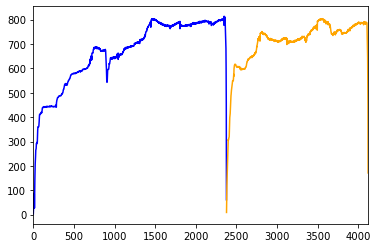

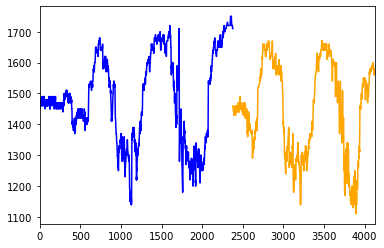

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  190  205  0        12       1550   70918669       0
1  191  205  0        34       1550   70918676       0
2  191  205  0        45       1560   70918683       0
3  191  204  0        51       1560   70918690       0
4  192  204  0        61       1570   70918697       0


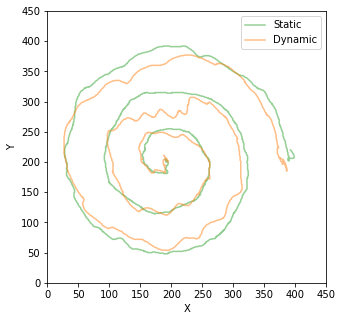

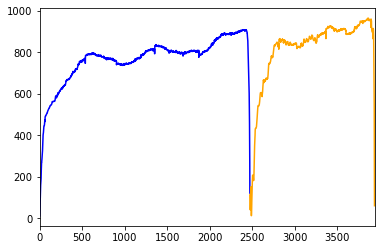

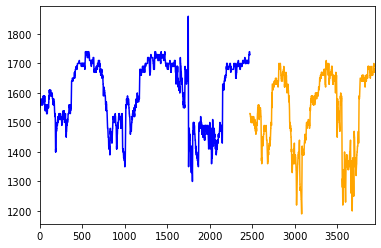

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  202  199  0         7       1390   71682228       0
1  202  199  0        22       1390   71682235       0
2  202  199  0        33       1400   71682242       0
3  202  198  0        61       1390   71682249       0
4  202  198  0        72       1390   71682256       0


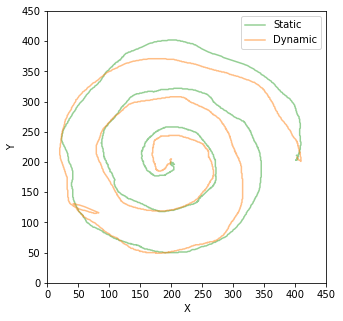

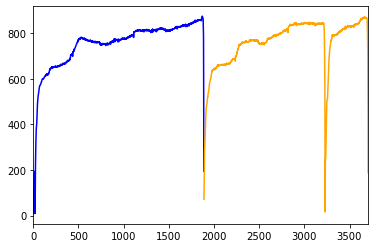

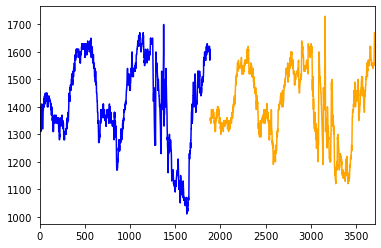

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  194  206  0        87       1760   75000214       0
1  194  205  0       116       1750   75000221       0
2  195  205  0       172       1750   75000228       0
3  195  205  0       196       1740   75000236       0
4  196  205  0       208       1750   75000243       0


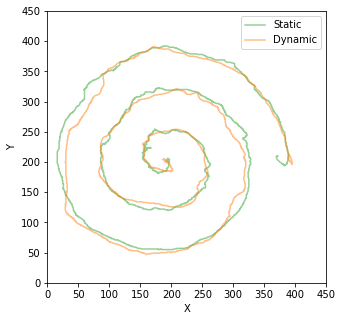

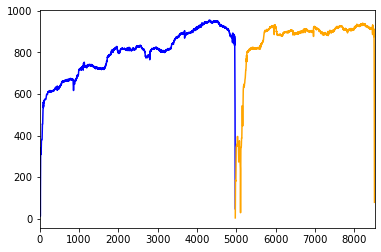

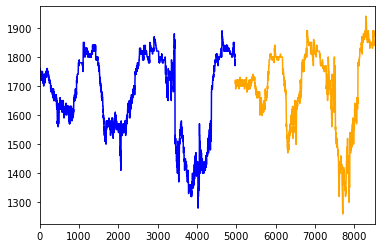

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  192  201  0        29       1260   75779447       0
1  193  201  0        77       1260   75779454       0
2  193  201  0       133       1260   75779461       0
3  193  201  0       149       1260   75779468       0
4  193  201  0       171       1260   75779475       0


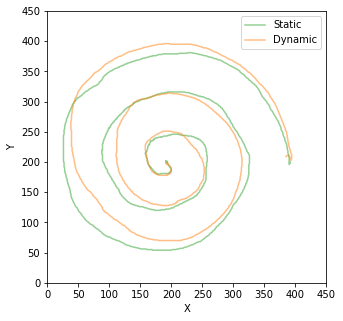

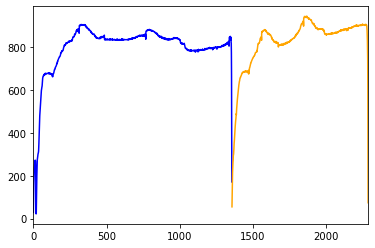

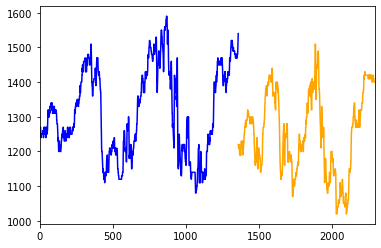

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  373  195  0         8       1480    6324964       0
1  373  195  0        38       1480    6324971       0
2  373  195  0        71       1470    6324978       0
3  373  194  0       106       1470    6324985       0
4  373  194  0       136       1480    6324992       0


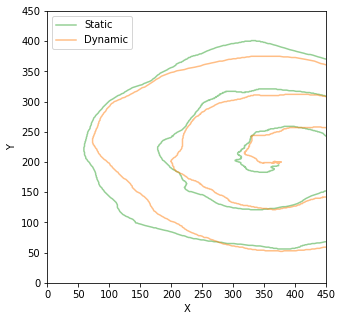

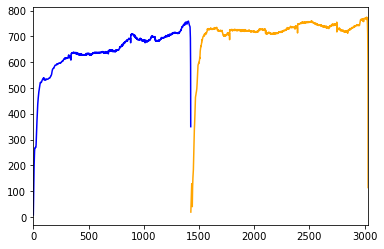

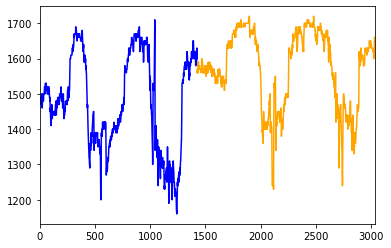

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  404  198  0        12       1400    8924920       0
1  404  198  0        23       1400    8924927       0
2  404  198  0        47       1400    8924934       0
3  404  198  0        80       1420    8924941       0
4  403  198  0       116       1430    8924948       0


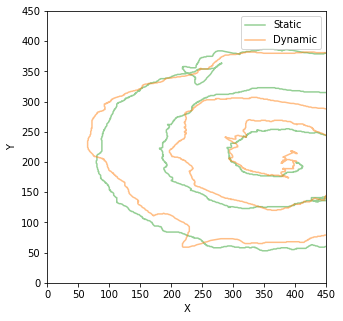

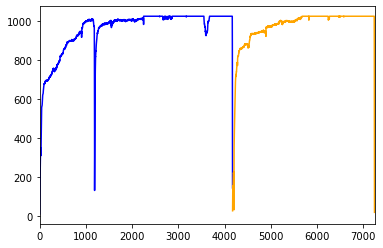

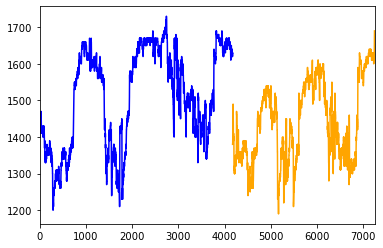

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  373  202  0         6       1330   10380546       0
1  373  202  0        33       1330   10380553       0
2  373  202  0        36       1330   10380560       0
3  372  202  0        36       1320   10380567       0
4  372  202  0        37       1330   10380574       0


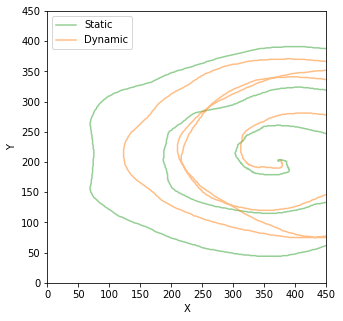

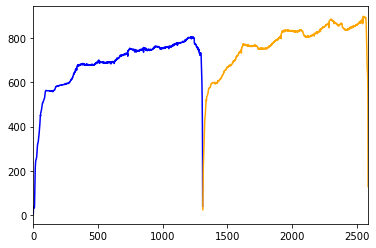

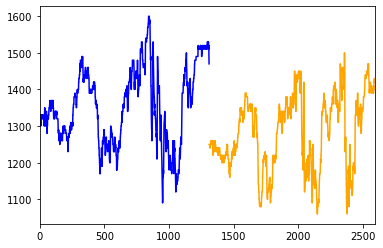

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  408  190  0         4       1310   12303255       0
1  408  190  0         6       1310   12303262       0
2  408  190  0         6       1310   12303269       0
3  408  190  0         6       1310   12303276       0
4  408  190  0         6       1310   12303283       0


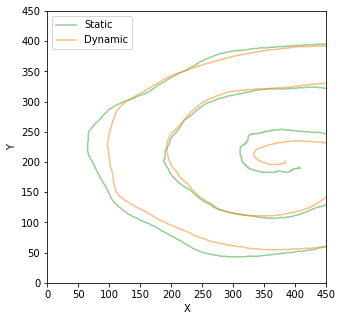

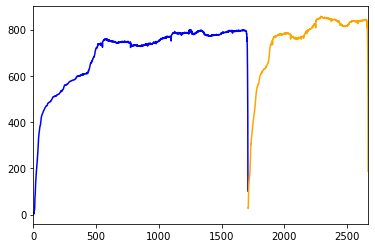

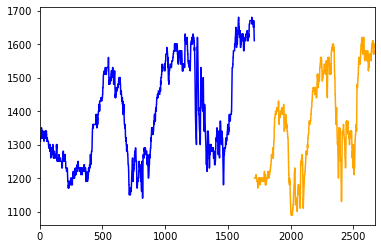

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  374  210  0        19       1530   13461869       0
1  374  210  0        73       1530   13461876       0
2  373  209  0       124       1530   13461883       0
3  373  209  0       156       1530   13461890       0
4  373  209  0       177       1530   13461897       0


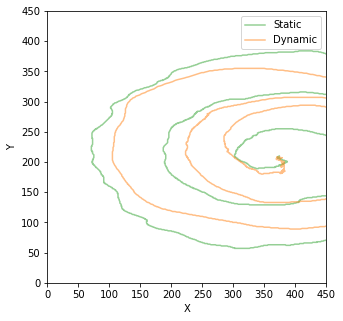

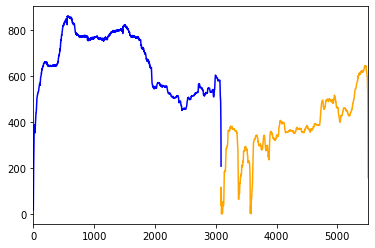

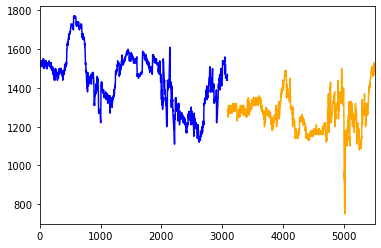

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  371  202  0        25       1130   14095993       0
1  371  201  0        61       1130   14096000       0
2  370  201  0        81       1130   14096007       0
3  370  201  0       100       1130   14096014       0
4  370  201  0       111       1120   14096021       0


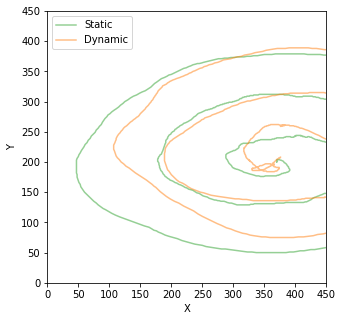

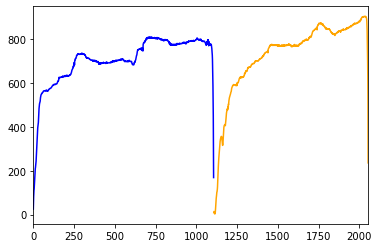

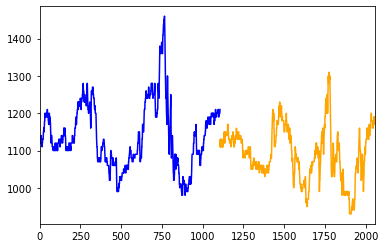

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  192  214  0         6       1380  1819512340       0
1  192  213  0        35       1380  1819512347       0
2  192  212  0        54       1390  1819512354       0
3  193  212  0        71       1390  1819512361       0
4  193  211  0        83       1380  1819512368       0


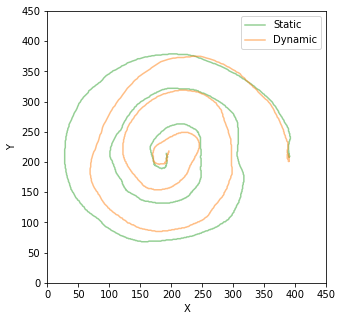

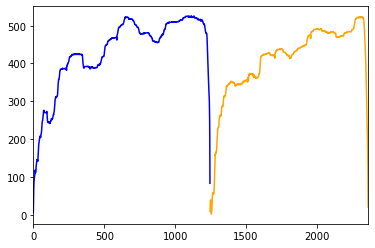

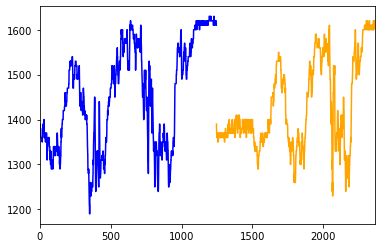

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  198  204  0        21       1230  1215567836       0
1  198  204  0       101       1230  1215567843       0
2  198  204  0        33       1260  1215567850       0
3  202  185  0         9       1220  1215568089       0
4  203  185  0        19       1220  1215568096       0


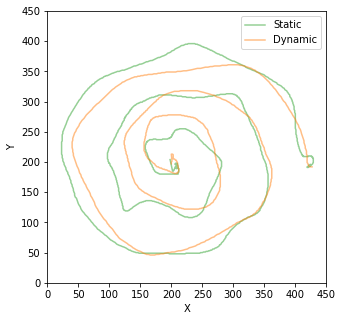

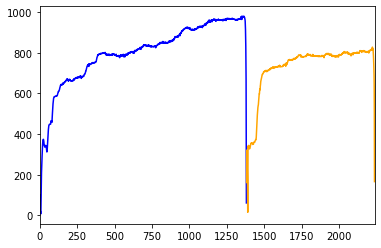

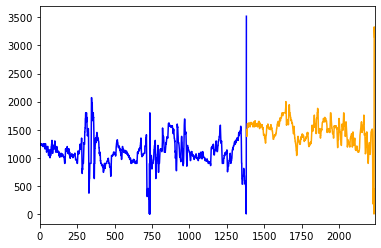

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  210  188  0         2       2650  1216355524       0
1  210  188  0        19       2640  1216355531       0
2  210  187  0        24       2650  1216355538       0
3  210  187  0        25       2700  1216355545       0
4  210  187  0        25       2700  1216355552       0


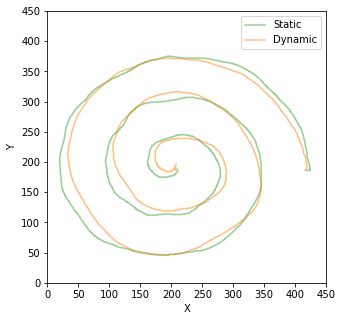

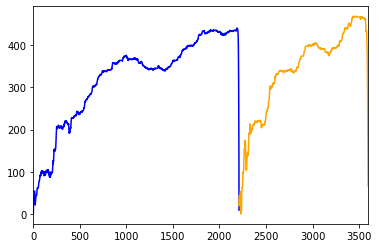

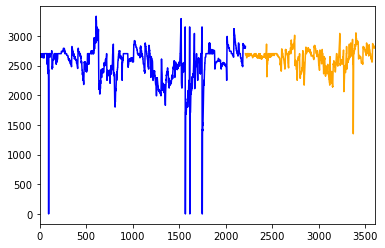

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  204  204  0       184       2460  1217130404       0
1  204  204  0       244       2450  1217130411       0
2  204  203  0       268       2450  1217130418       0
3  204  203  0       274       2480  1217130425       0
4  204  203  0       287       2450  1217130432       0


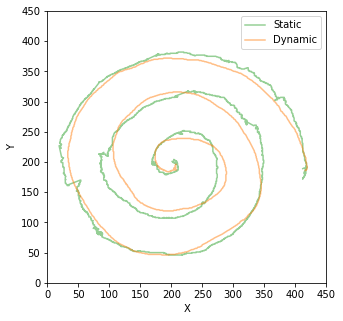

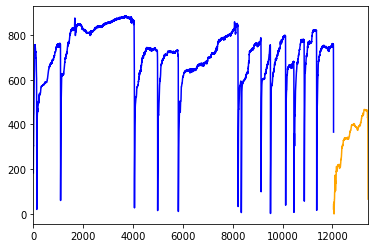

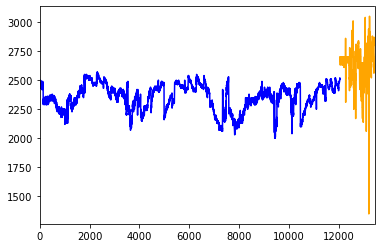

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  214  205  0        14        710  1813494849       0
1  214  204  0        30        710  1813494856       0
2  214  204  0        34        710  1813494863       0
3  213  204  0        35        710  1813494870       0
4  213  203  0        35        710  1813494877       0


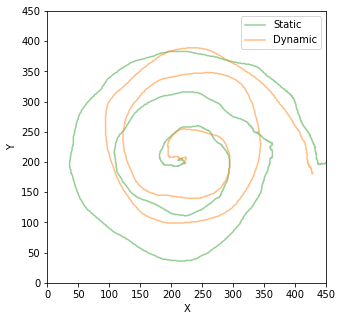

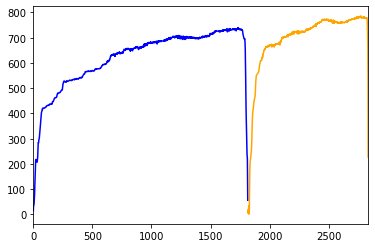

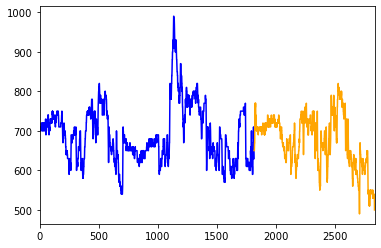

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  204  199  0        12        570  1814814698       0
1  203  199  0        30        540  1814814705       0
2  203  199  0        39        570  1814814712       0
3  203  199  0        78        580  1814814719       0
4  203  199  0        97        580  1814814726       0


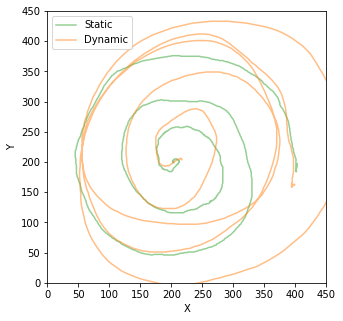

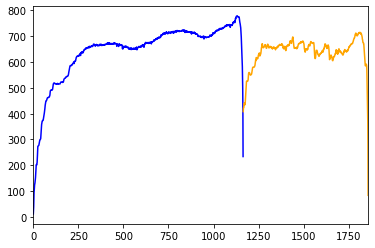

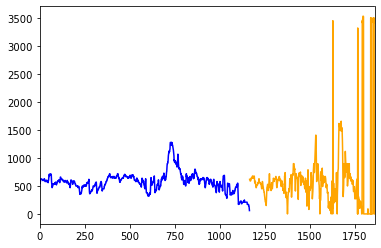

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  197  192  0        22        640  1817162961       0
1  197  192  0        42        640  1817162968       0
2  197  192  0        53        640  1817162975       0
3  197  192  0        56        630  1817162982       0
4  197  192  0        61        620  1817162989       0


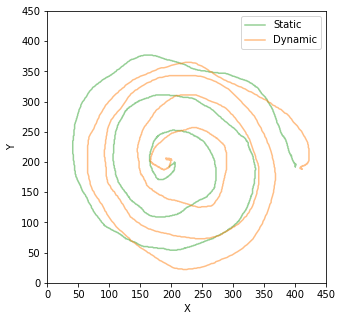

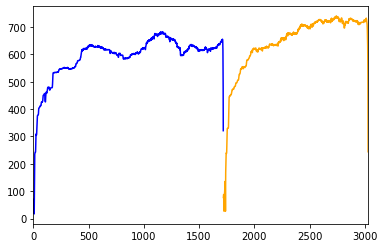

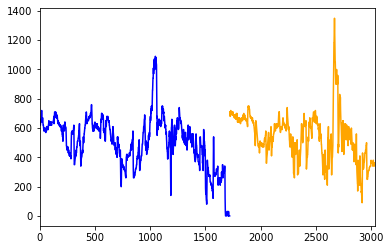

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  200  203  0        13       1450  1818152970       0
1  199  202  0        66       1450  1818152977       0
2  198  202  0        87       1440  1818152984       0
3  198  202  0       116       1440  1818152991       0
4  198  201  0       136       1450  1818152998       0


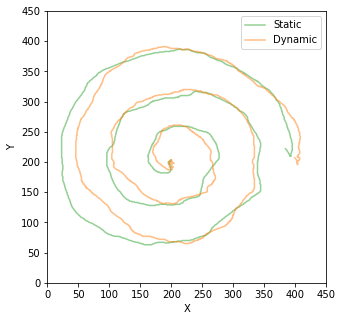

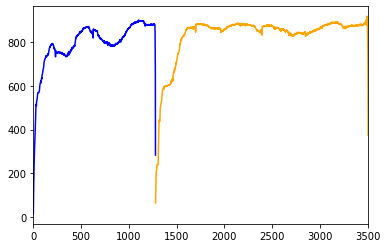

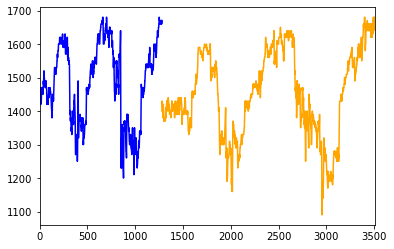

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  198  201  0        25       1260  1822077962       0
1  197  201  0        62       1260  1822077969       0
2  197  201  0        86       1260  1822077976       0
3  196  200  0        99       1260  1822077983       0
4  196  200  0       105       1260  1822077990       0


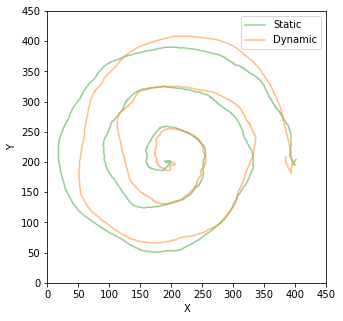

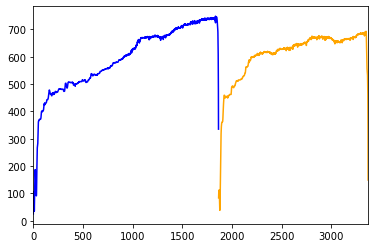

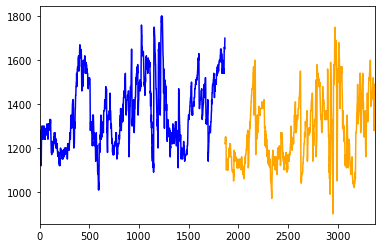

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  199  208  0        79       1480  1822880095       0
1  198  207  0       361       1460  1822880102       0
2  198  206  0       398       1460  1822880109       0
3  197  205  0       421       1470  1822880116       0
4  197  205  0       449       1460  1822880123       0


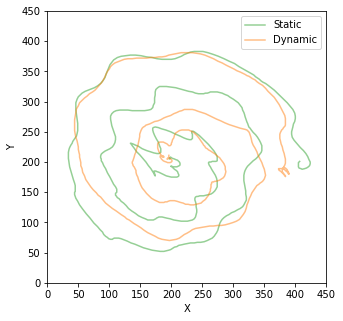

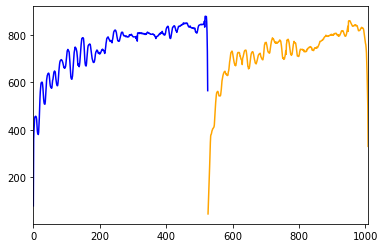

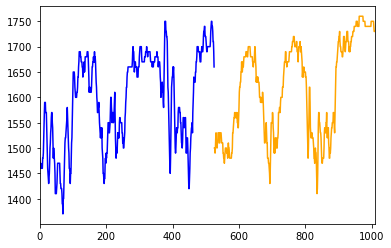

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  208  208  0        99        720  2417558975       0
1  208  209  0       136        720  2417558982       0
2  208  209  0       162        720  2417558989       0
3  209  209  0       168        730  2417558996       0
4  209  209  0       127        730  2417559004       0


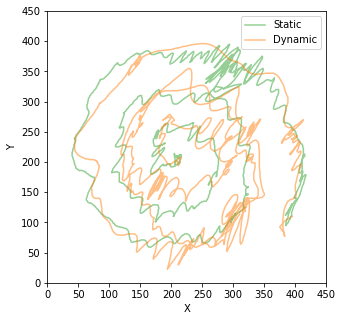

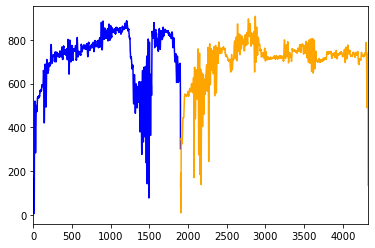

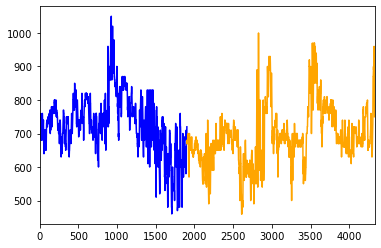

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  209  201  0         1        710  2419243170       0
1  209  201  0         3        710  2419243177       0
2  210  201  0         3        710  2419243184       0
3  210  201  0         3        710  2419243191       0
4  210  201  0         4        710  2419243198       0


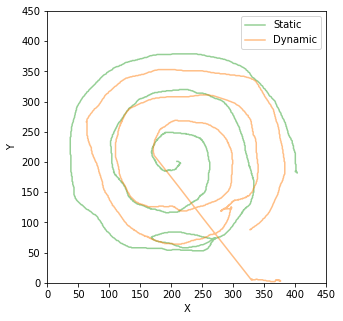

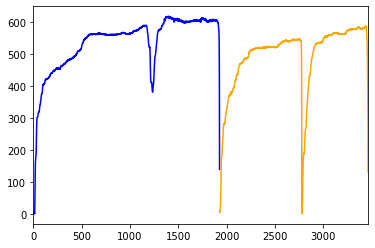

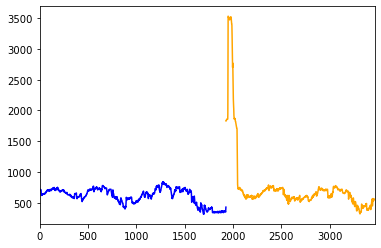

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  201  204  0         3        460  2420719377       0
1  201  204  0        20        460  2420719384       0
2  201  203  0        35        450  2420719391       0
3  200  203  0        39        460  2420719398       0
4  200  203  0        41        460  2420719405       0


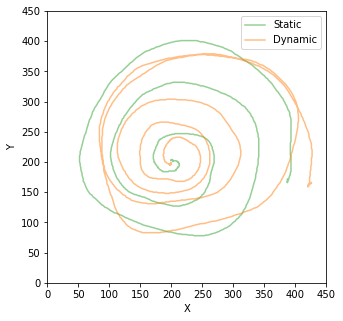

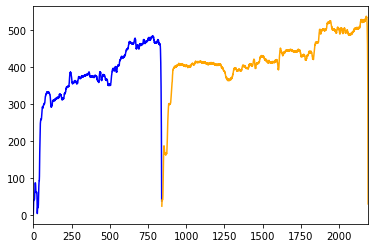

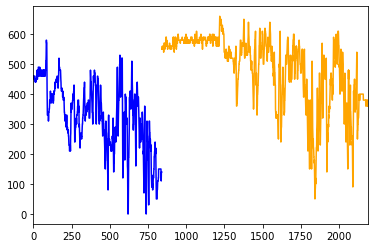

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  200  206  0        29        650  2421850500       0
1  200  206  0        52        650  2421850507       0
2  200  206  0        73        650  2421850514       0
3  200  206  0        84        650  2421850521       0
4  200  206  0        85        650  2421850528       0


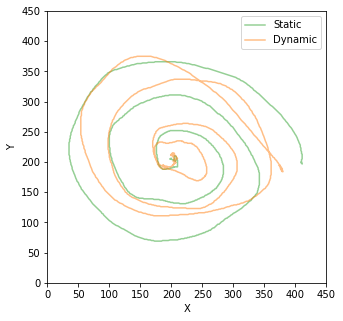

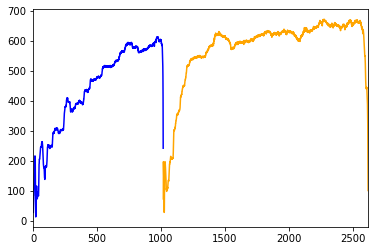

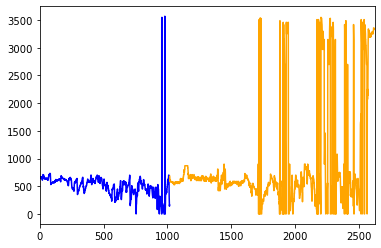

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  204  205  0        70        730  2425244421       0
1  204  204  0       163        720  2425244428       0
2  203  204  0       257        720  2425244435       0
3  203  203  0       327        720  2425244442       0
4  203  203  0       363        720  2425244449       0


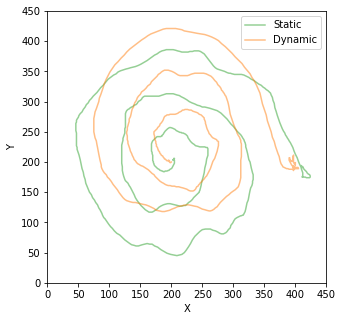

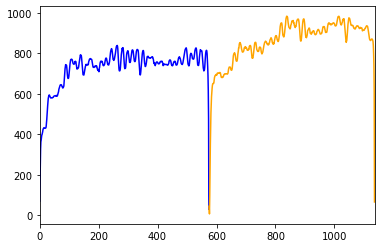

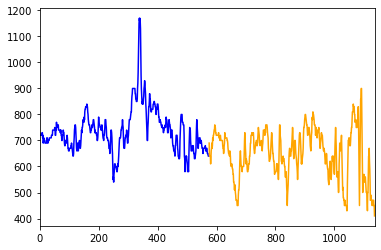

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  372  203  0        60       1330    4924970       0
1  375  201  0       191       1350    4924977       0
2  377  200  0       193       1350    4924984       0
3  379  199  0       181       1370    4924991       0
4  381  198  0       169       1350    4924998       0


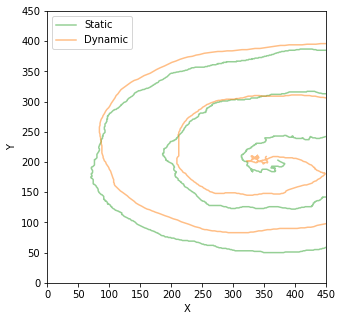

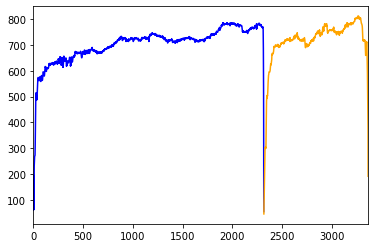

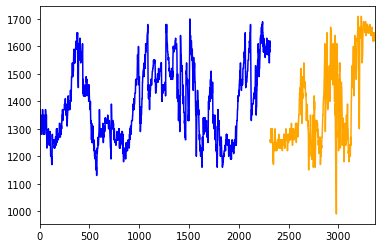

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  211  194  0        39        470  1812430773       0
1  210  194  0        42        470  1812430780       0
2  210  194  0        45        470  1812430787       0
3  210  194  0        55        470  1812430795       0
4  209  194  0        70        450  1812430802       0


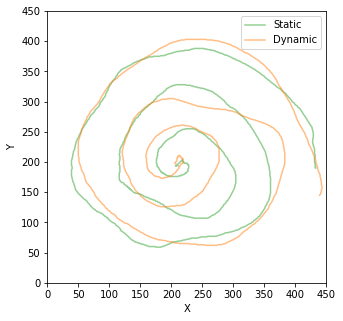

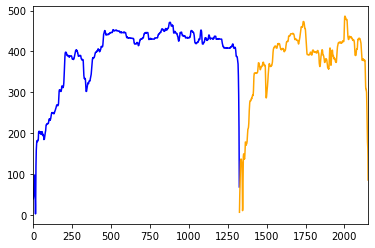

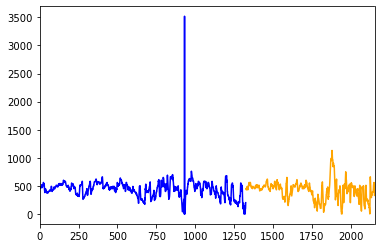

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  210  190  0       114        370  1372359999       0
1  209  191  0       141        370  1372360006       0
2  209  192  0       145        350  1372360013       0
3  209  192  0       151        350  1372360020       0
4  209  193  0       157        350  1372360027       0


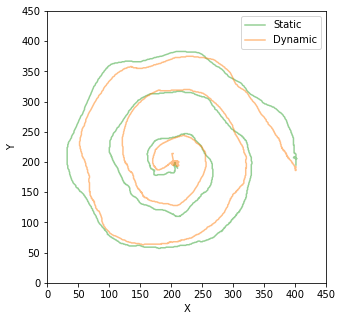

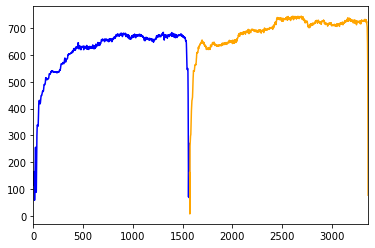

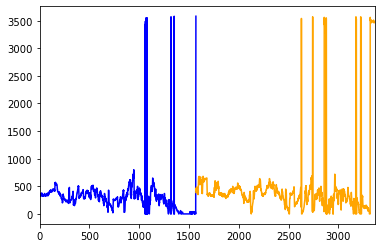

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  206  180  0         1        690  1373404847       0
1  206  180  0        30        690  1373404855       0
2  206  179  0        45        690  1373404862       0
3  206  179  0        51        690  1373404869       0
4  206  179  0        54        690  1373404876       0


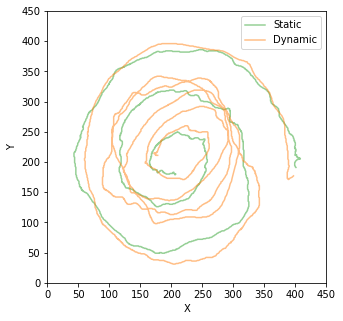

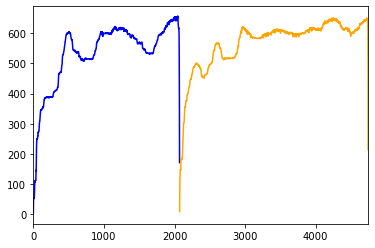

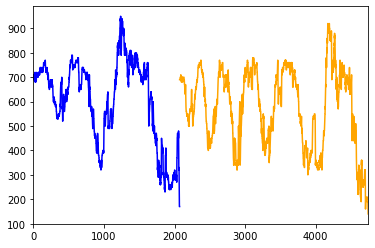

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  201  202  0       163        830  1374859677       0
1  201  202  0       181        830  1374859684       0
2  201  201  0       194        830  1374859691       0
3  201  201  0       188        830  1374859698       0
4  200  200  0       181        830  1374859705       0


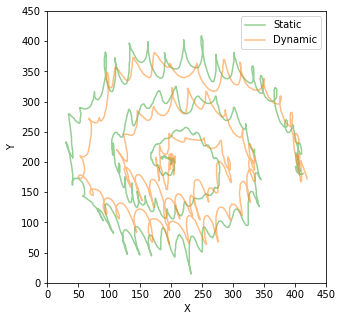

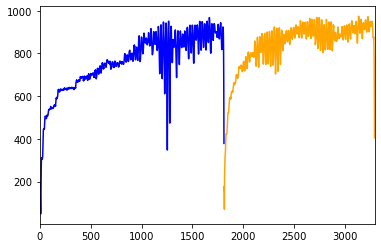

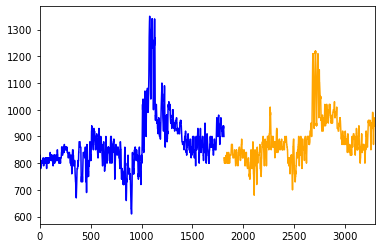

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  213  205  0        15       1440    1351716       0
1  213  205  0        47       1440    1351725       0
2  213  205  0        68       1440    1351734       0
3  213  205  0        84       1420    1351743       0
4  214  205  0        88       1440    1351752       0


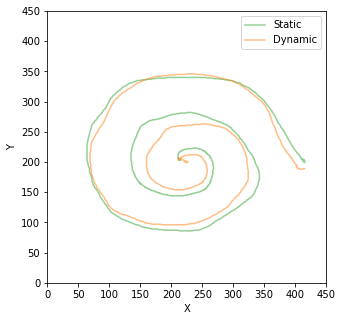

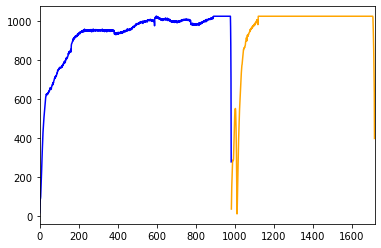

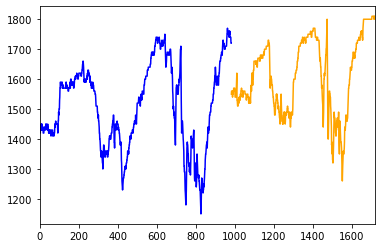

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  220  203  0         9       1240    3021041       0
1  220  202  0        22       1250    3021050       0
2  221  201  0        45       1230    3021059       0
3  221  201  0        61       1220    3021068       0
4  221  201  0        74       1230    3021077       0


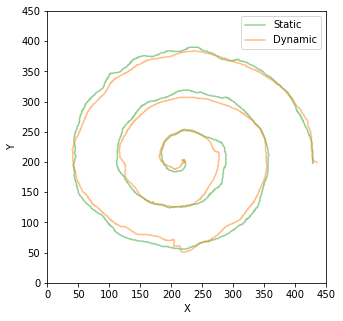

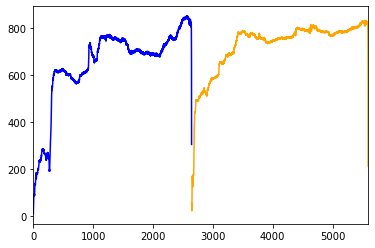

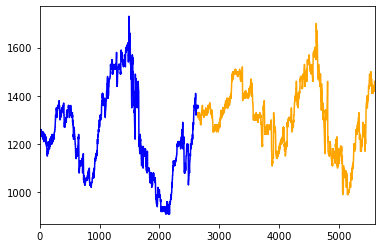

After reading file:       X    Y   Z  Pressure  GripAngle  Timestamp  TestID
0  204  209  28        99       1230   13116870       0
1  206  207   0        54       1240   13116879       0
2  207  205   0        29       1230   13116888       0
3  199  208  80        96       1250   13117374       0
4  199  208   0       115       1250   13117383       0


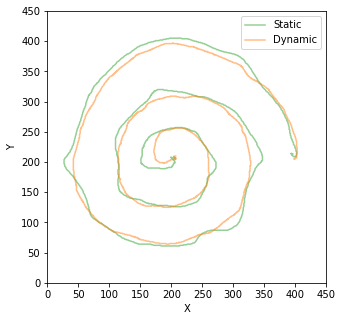

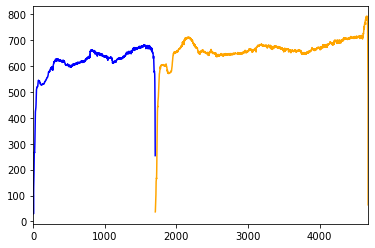

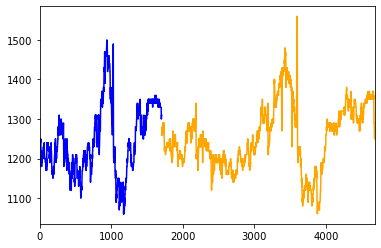

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  208  203  0        24       1110   14044951       0
1  208  203  0        41       1100   14044960       0
2  208  203  0        54       1110   14044969       0
3  208  203  0        70       1100   14044978       0
4  208  203  0        87       1100   14044987       0


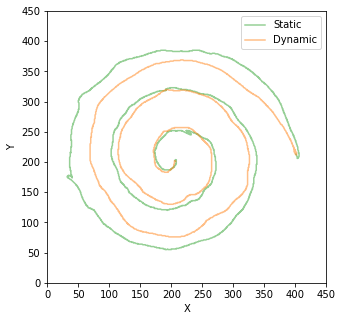

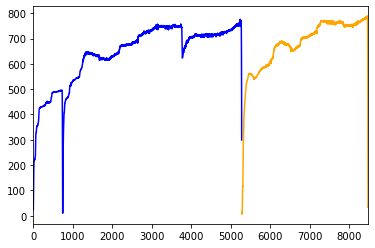

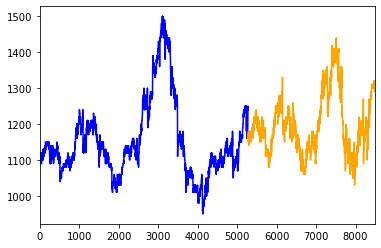

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  214  203  0         2       1000    2315210       0
1  214  203  0         2       1010    2315219       0
2  214  203  0         3       1010    2315228       0
3  214  203  0         2       1010    2315237       0
4  214  203  0         2       1000    2315246       0


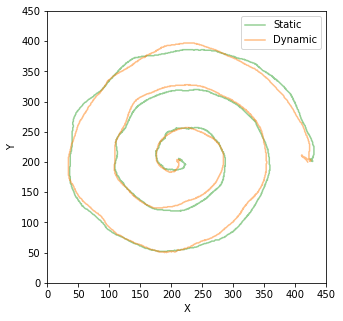

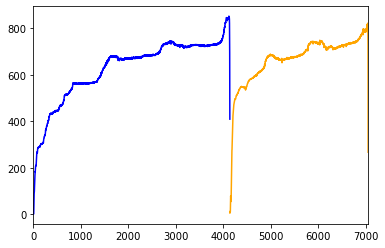

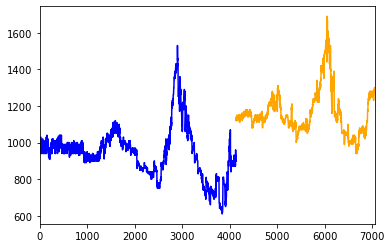

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  217  203  0         6       1210    3955176       0
1  217  203  0        29       1210    3955185       0
2  217  203  0        83       1190    3955194       0
3  217  203  0       141       1180    3955203       0
4  217  202  0       183       1180    3955212       0


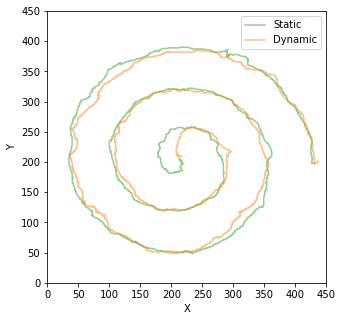

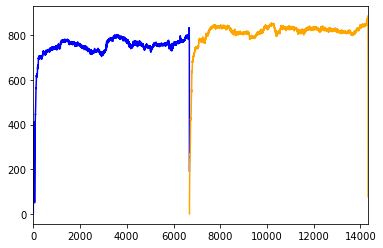

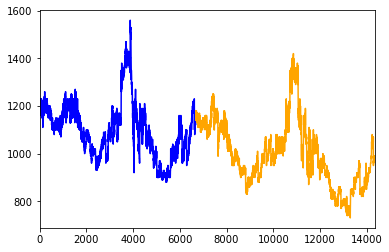

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  218  200  0         7       1060    8344153       0
1  217  200  0        19       1060    8344162       0
2  217  199  0        17       1060    8344171       0
3  217  199  0        21       1050    8344180       0
4  217  199  0        21       1050    8344189       0


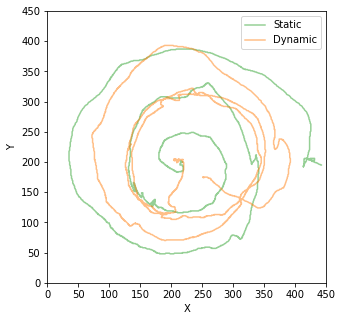

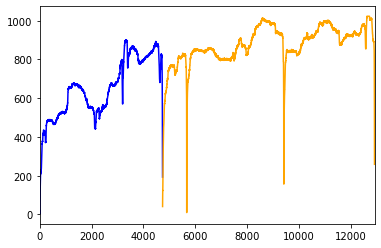

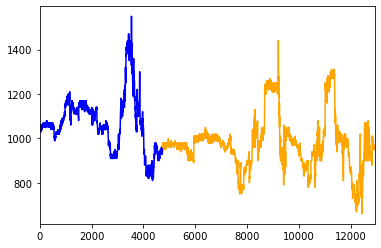

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  203  198  0         9       1010    4595661       0
1  203  198  0        19       1010    4595670       0
2  202  198  0        34       1000    4595679       0
3  202  198  0        48       1010    4595688       0
4  202  198  0        68       1000    4595697       0


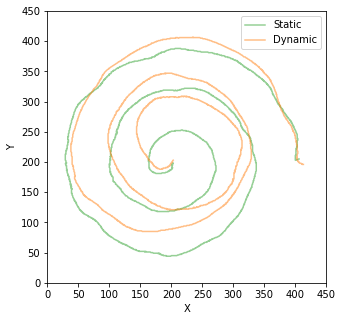

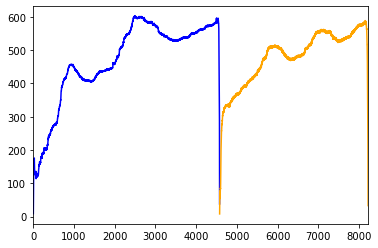

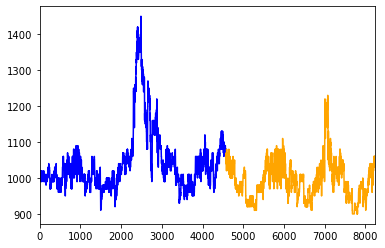

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  210  198  0         8       1070    7192634       0
1  210  198  0        29       1060    7192643       0
2  210  198  0        54       1030    7192652       0
3  210  198  0        71       1010    7192661       0
4  209  198  0        81       1000    7192670       0


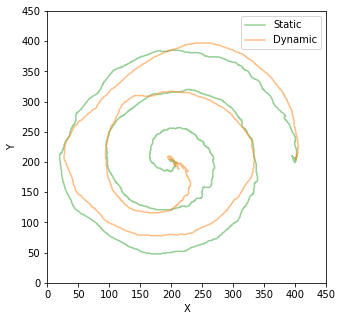

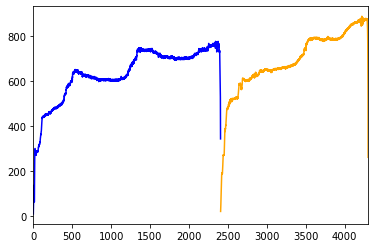

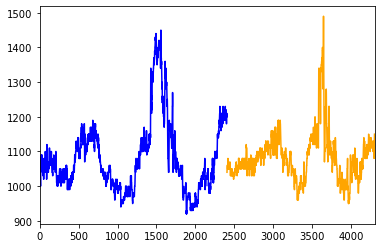

After reading file:       X    Y   Z  Pressure  GripAngle  Timestamp  TestID
0  196  208   0        15       1190    9524156       0
1  196  208   0        30       1180    9524165       0
2  196  208   0        45       1170    9524174       0
3  196  208   0        61       1170    9524183       0
4  196  207  12        79       1150    9524192       0


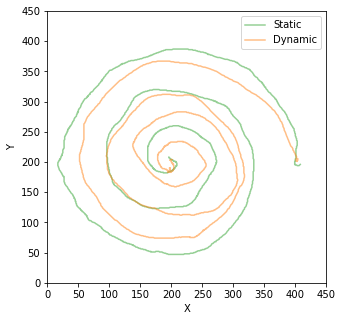

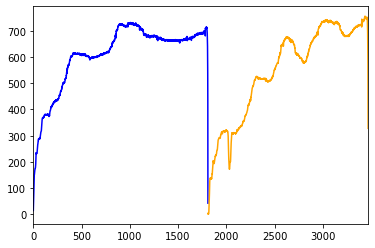

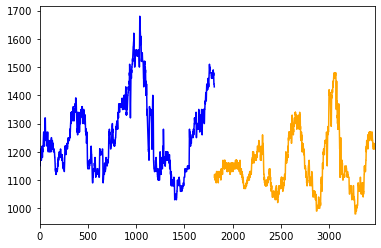

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  226  192  0       350       1240   12260295       0
1  227  190  0       341       1260   12260304       0
2  228  189  0       344       1250   12260313       0
3  228  189  0       355       1250   12260322       0
4  229  188  0       354       1270   12260331       0


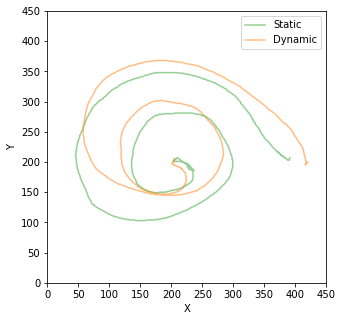

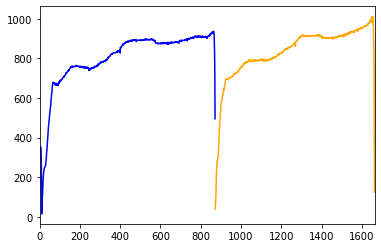

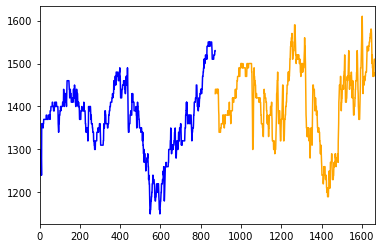

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  207  190  0         2       1320   13040829       0
1  207  189  0        19       1330   13040838       0
2  207  189  0        42       1340   13040847       0
3  207  189  0        58       1340   13040856       0
4  207  189  0        77       1340   13040865       0


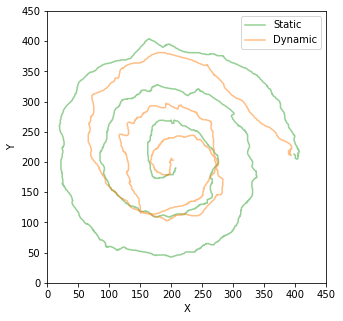

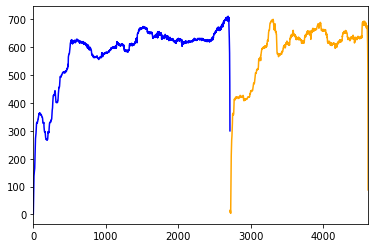

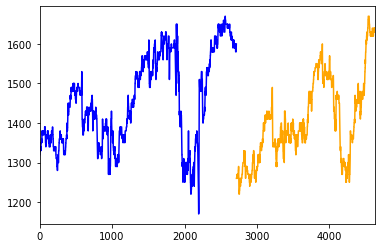

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  218  204  0        21       1180    8128263       0
1  217  203  0        49       1160    8128272       0
2  217  203  0        70       1170    8128281       0
3  217  203  0        85       1160    8128290       0
4  216  203  0       100       1170    8128299       0


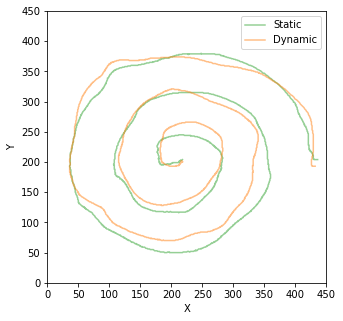

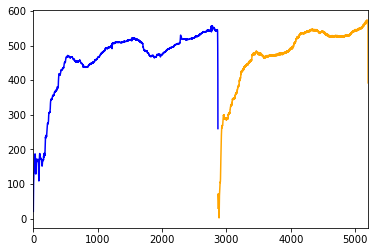

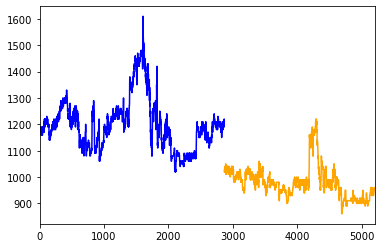

After reading file:       X    Y   Z  Pressure  GripAngle  Timestamp  TestID
0  208  215  12         2       1240   10515464       0
1  209  214   0         9       1240   10515473       0
2  209  213  12        13       1240   10515482       0
3  209  213   0        12       1230   10515491       0
4  210  212   0        12       1240   10515500       0


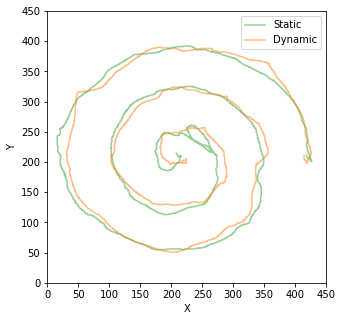

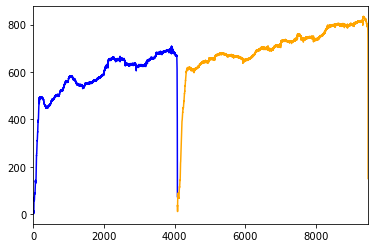

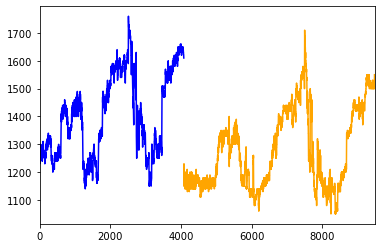

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  204  200  0       188        940    2896479       0
1  204  200  0       217        940    2896488       0
2  204  200  0       276        940    2896497       0
3  204  200  0       300        940    2896506       0
4  204  200  0       304        940    2896515       0


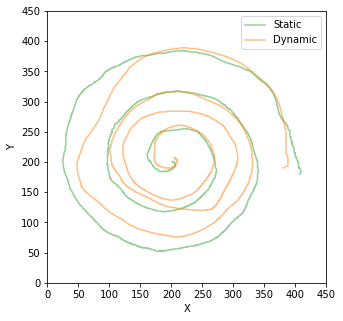

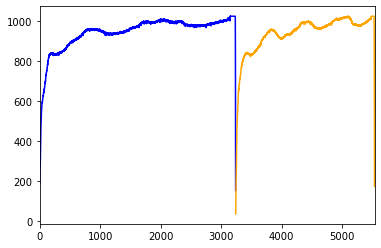

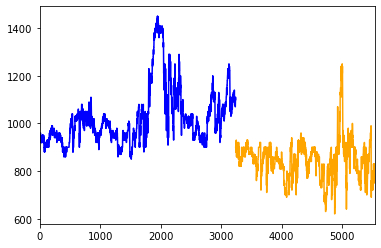

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  198  205  0         7       1150    4420070       0
1  197  205  0        19       1150    4420079       0
2  197  205  0        24       1150    4420088       0
3  197  205  0        28       1160    4420097       0
4  197  205  0        38       1160    4420106       0


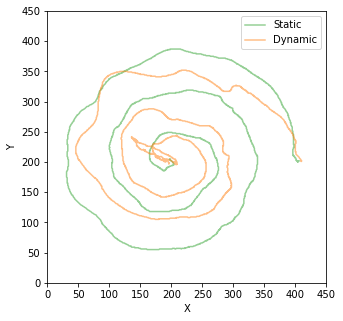

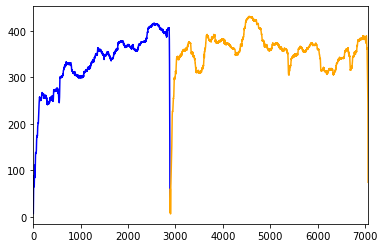

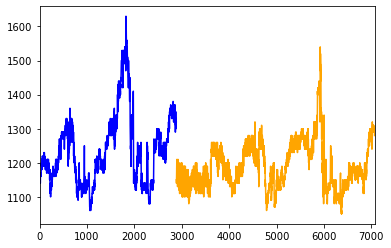

After reading file:       X    Y   Z  Pressure  GripAngle  Timestamp  TestID
0  270  202  24         8       1270    4142080       0
1  270  202   0        58       1280    4142089       0
2  270  202  12        93       1280    4142098       0
3  270  202   0       110       1280    4142107       0
4  270  202  12       122       1270    4142116       0


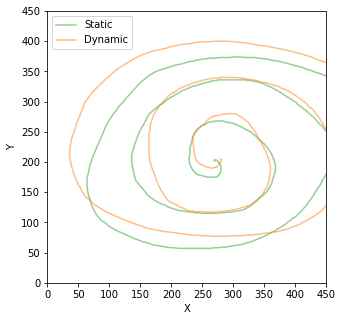

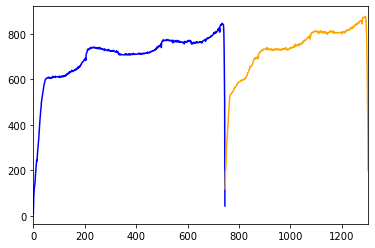

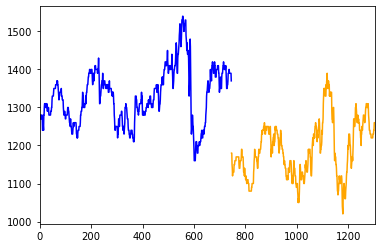

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  274  206  0       178       1490    5482221       0
1  273  206  0       222       1490    5482230       0
2  273  206  0       261       1480    5482239       0
3  273  206  0       273       1480    5482248       0
4  273  206  0       283       1480    5482257       0


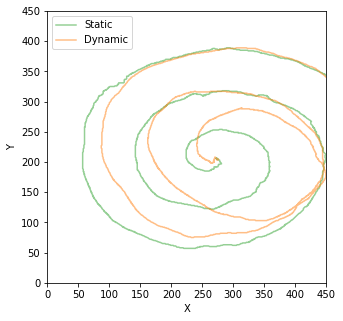

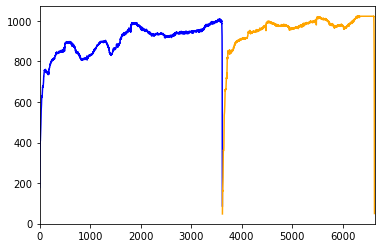

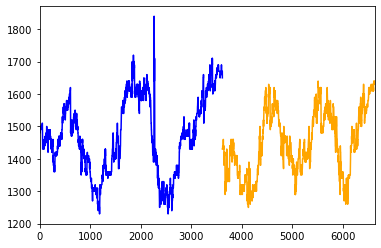

After reading file:       X    Y   Z  Pressure  GripAngle  Timestamp  TestID
0  281  201   0         4        900    6945632       0
1  281  201   0         9        900    6945641       0
2  280  201   0         9        900    6945650       0
3  280  201   0         9        890    6945659       0
4  281  201  12        16        900    6945992       0


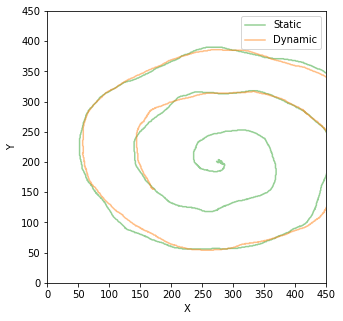

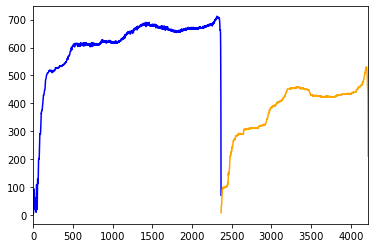

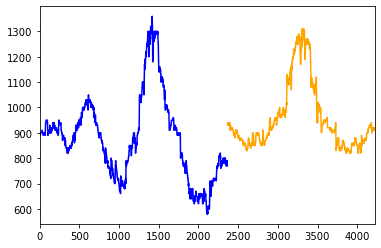

After reading file:       X    Y   Z  Pressure  GripAngle  Timestamp  TestID
0  274  200   0         6       1060   10612109       0
1  274  200   0        28       1050   10612118       0
2  274  200   0        46       1070   10612127       0
3  275  200   0        64       1070   10612136       0
4  275  200  12        73       1070   10612145       0


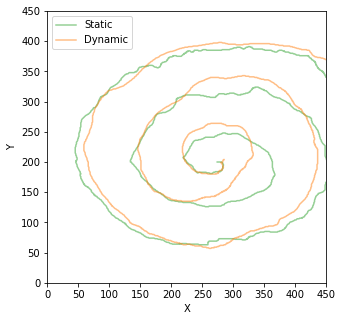

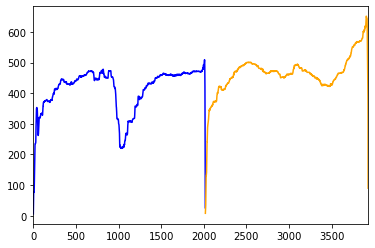

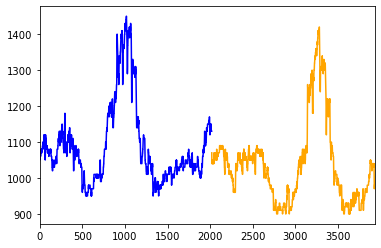

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  282  202  0         1        900   12497798       0
1  281  202  0         7        900   12497807       0
2  281  201  0        15        900   12497816       0
3  281  201  0        38        900   12497825       0
4  281  201  0        63        900   12497834       0


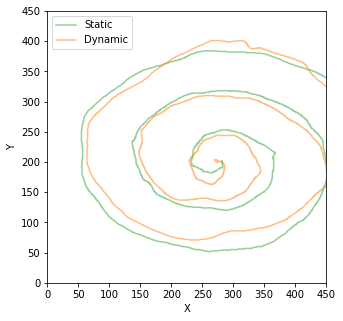

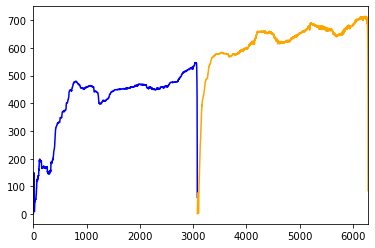

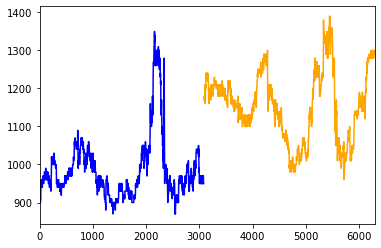

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  205  205  0         2       1140    1838654       0
1  205  204  0        12       1140    1838663       0
2  205  204  0        33       1140    1838672       0
3  205  204  0        51       1140    1838681       0
4  205  204  0        61       1140    1838690       0


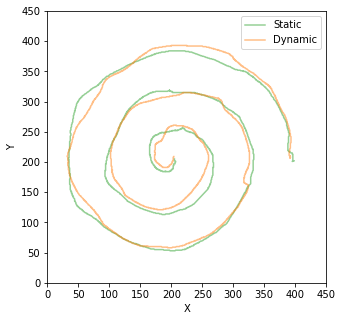

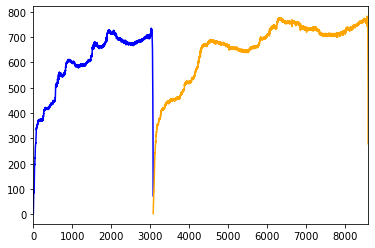

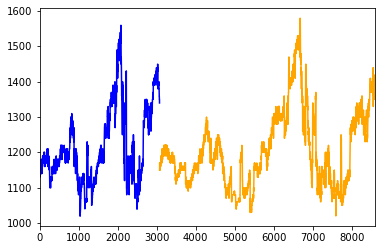

After reading file:       X    Y   Z  Pressure  GripAngle  Timestamp  TestID
0  247  216   0        23        900    7758654       0
1  245  216   0        24        900    7758663       0
2  244  215   0        33        900    7758672       0
3  243  215   0        39        900    7758681       0
4  243  214  12        46        900    7758690       0


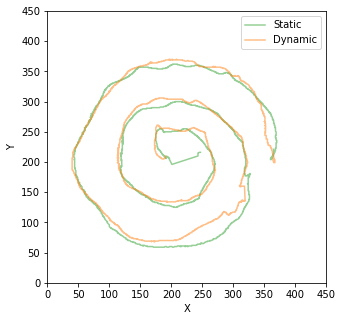

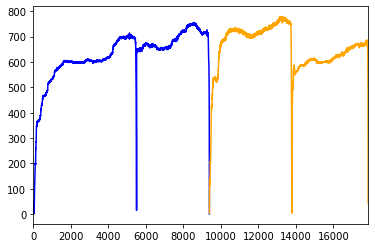

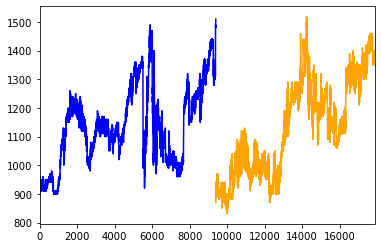

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  198  199  0        64        990    2717202       0
1  197  200  0       100       1030    2717211       0
2  197  200  0       140       1030    2717220       0
3  196  200  0       175       1030    2717229       0
4  196  200  0       188       1010    2717238       0


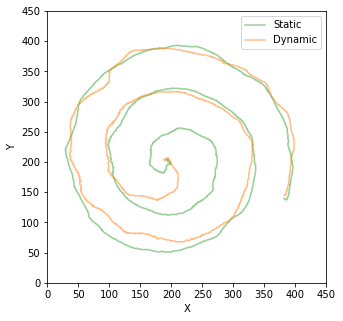

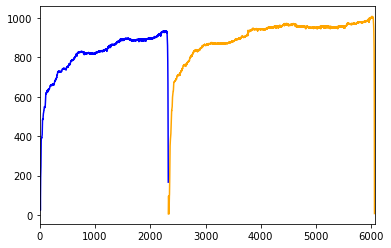

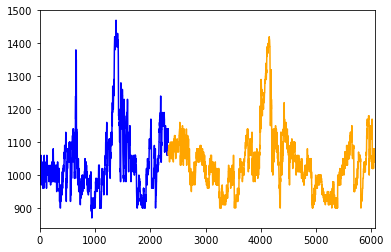

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  204  201  0         2        870    4003879       0
1  204  201  0        22        890    4003888       0
2  204  201  0        50        890    4003897       0
3  204  201  0        78        890    4003906       0
4  204  201  0       106        900    4003915       0


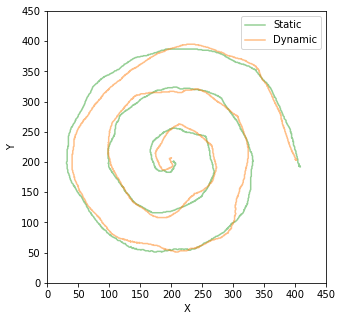

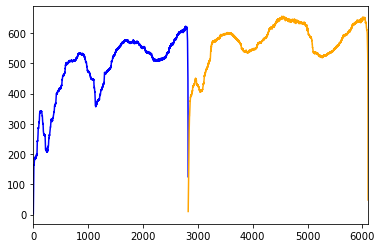

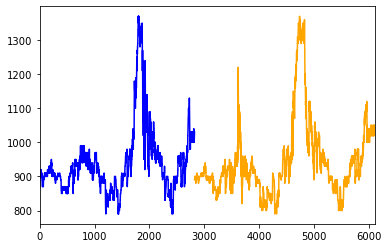

In [9]:
for i in range(len(park_file)): 
    (df,file)=read_file(park_file,i)
    get_plot(df)
    df_combined=get_combined(df) 
    df_combined=get_feature(df_combined)
    data=get_mean_var(df_combined)
    save(data,file)

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  200  204  0        73        910  1732647300       0
1  200  204  0       218        900  1732647307       0
2  200  204  0       253        900  1732647314       0
3  200  204  0       304        900  1732647321       0
4  200  204  0       351        900  1732647328       0
file sequence: 0


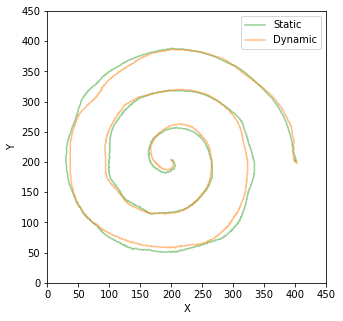

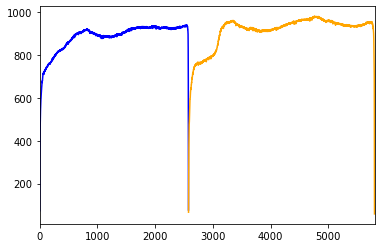

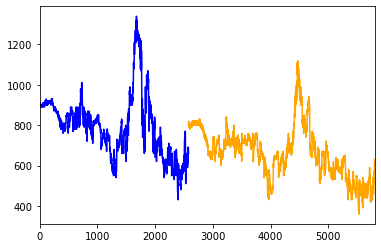

After reading file:       X    Y   Z  Pressure  GripAngle   Timestamp  TestID
0  199  202   0       126        860  1732464831       0
1  199  202   0       202        860  1732464838       0
2  199  202   0       276        860  1732464845       0
3  199  202  12       328        860  1732464852       0
4  199  202   0       373        860  1732464859       0
file sequence: 1


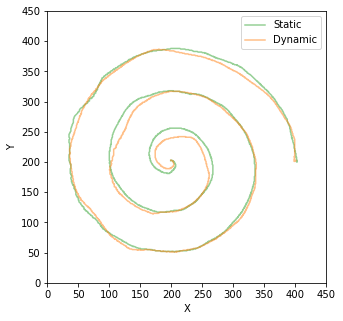

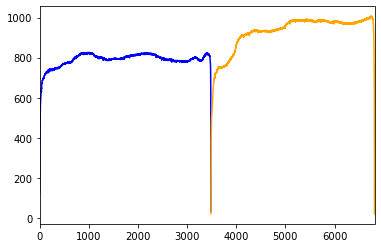

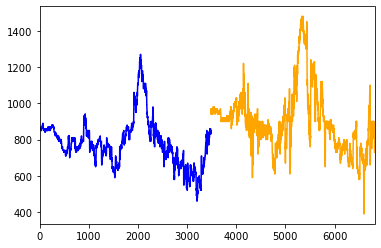

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  226  234  0        42        960    1283177       0
1  226  234  0        80        960    1283186       0
2  226  234  0       119        960    1283195       0
3  226  234  0       161        960    1283204       0
4  226  234  0       194        980    1283213       0
file sequence: 2


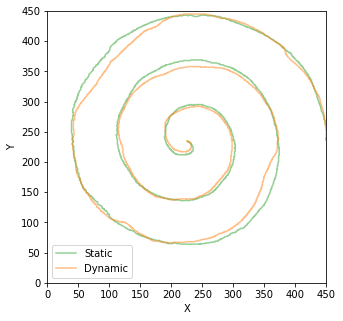

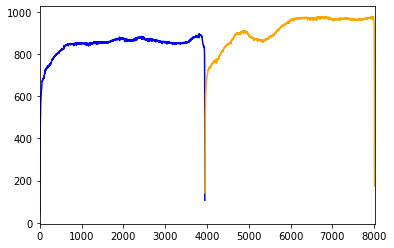

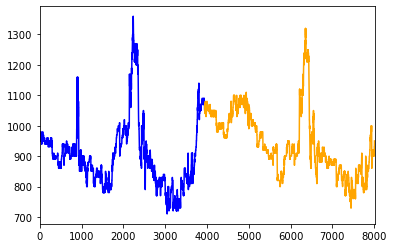

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  200  203  0        73       1100     290479       0
1  200  203  0       149       1100     290486       0
2  200  203  0       227       1110     290493       0
3  199  203  0       288       1110     290500       0
4  199  203  0       334       1110     290507       0
file sequence: 3


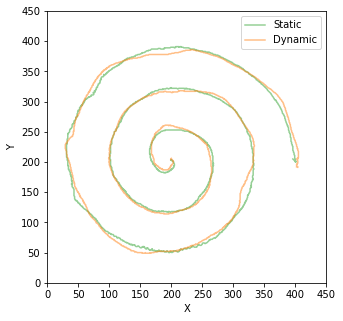

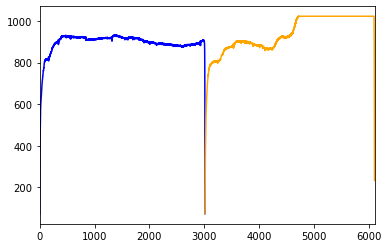

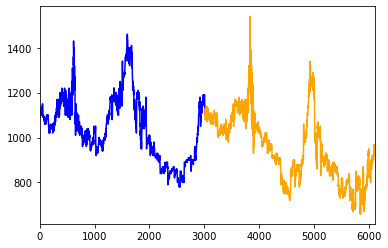

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  201  202  0       110        900  1732864374       0
1  201  202  0       267        890  1732864381       0
2  201  202  0       273        900  1732864388       0
3  201  202  0       297        900  1732864395       0
4  201  202  0       354        900  1732864402       0
file sequence: 4


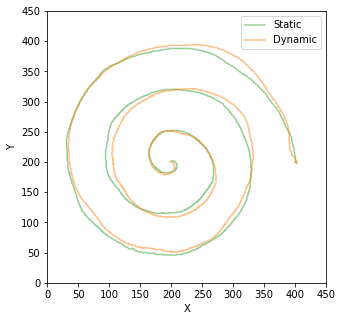

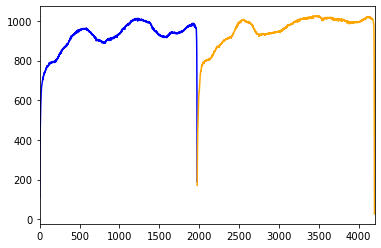

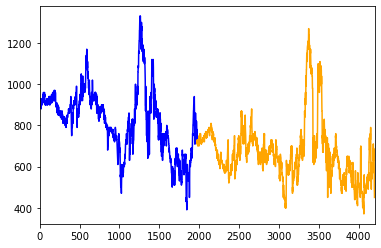

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  199  203  0       347        970  1732697382       0
1  199  203  0       354       1000  1732697389       0
2  199  203  0       373        990  1732697396       0
3  199  203  0       418        990  1732697403       0
4  199  203  0       446        980  1732697410       0
file sequence: 5


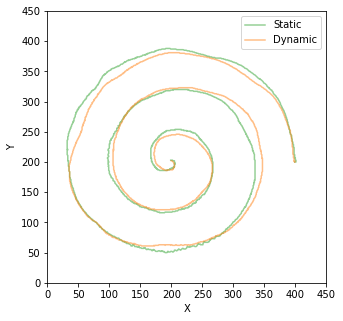

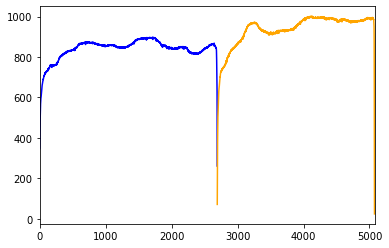

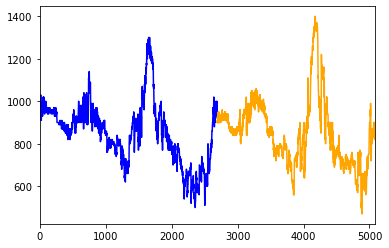

After reading file:       X    Y  Z  Pressure  GripAngle   Timestamp  TestID
0  198  204  0       143        900  1732805582       0
1  198  204  0       267        890  1732805589       0
2  198  204  0       299        890  1732805596       0
3  198  204  0       365        890  1732805603       0
4  198  204  0       411        880  1732805610       0
file sequence: 6


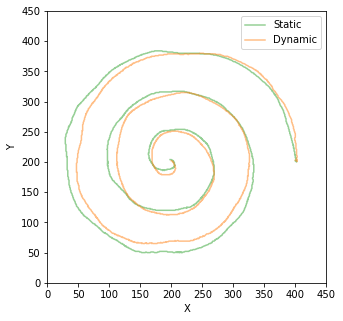

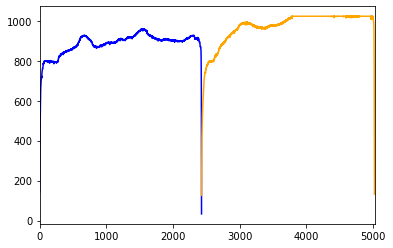

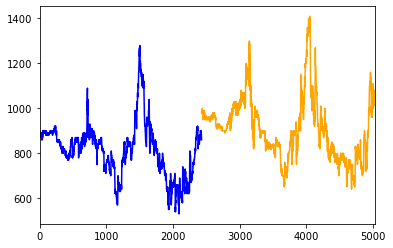

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  201  204  0        25       1320    3768030       0
1  201  204  0        62       1320    3768037       0
2  201  204  0        74       1310    3768044       0
3  201  204  0        77       1310    3768051       0
4  201  203  0        78       1310    3768058       0
file sequence: 7


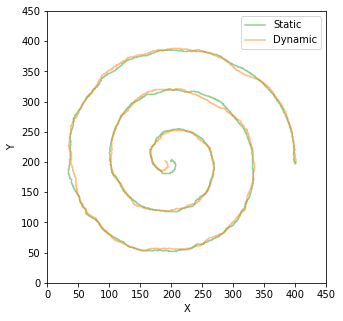

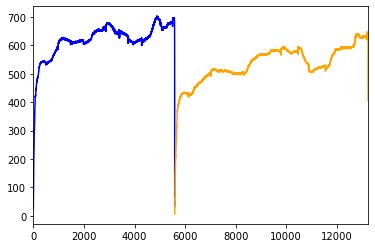

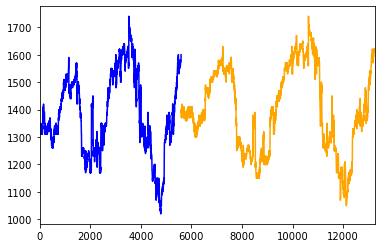

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  202  203  0         9       1300    6382422       0
1  202  203  0        53       1290    6382429       0
2  202  203  0        77       1280    6382436       0
3  202  203  0       104       1280    6382443       0
4  202  203  0       149       1290    6382450       0
file sequence: 8


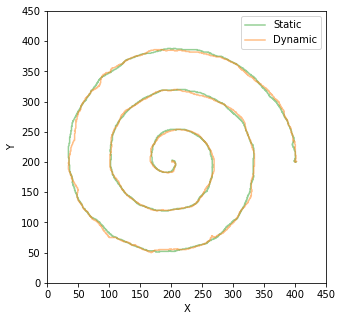

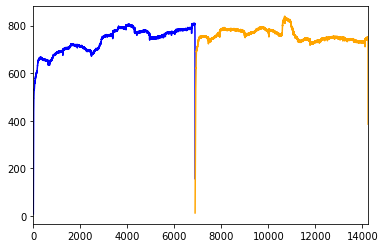

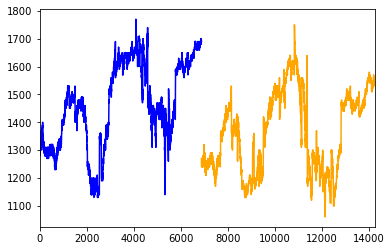

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  199  203  0         1        990   14431033       0
1  199  203  0         9        970   14431040       0
2  199  203  0        20        960   14431047       0
3  199  203  0        30        970   14431054       0
4  199  203  0        45        970   14431061       0
file sequence: 9


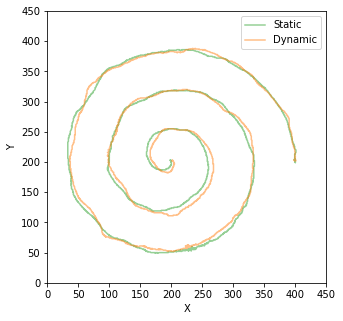

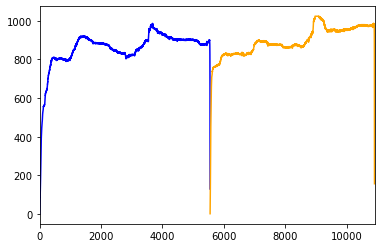

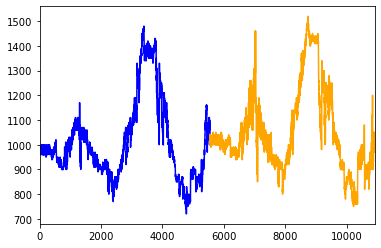

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  197  202  0         3       1180   14769976       0
1  197  202  0        13       1170   14769983       0
2  197  202  0        16       1160   14769990       0
3  197  202  0        29       1160   14769997       0
4  197  202  0        39       1170   14770004       0
file sequence: 10


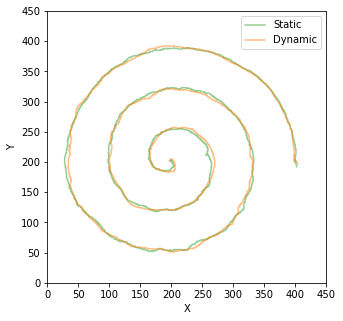

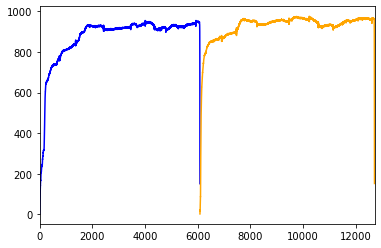

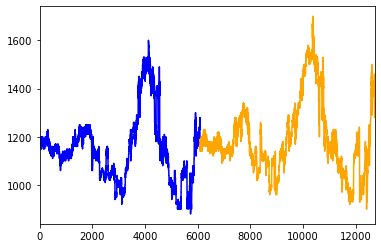

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  192  202  0        13       1200   15122711       0
1  192  202  0        29       1200   15122718       0
2  191  202  0        35       1220   15122725       0
3  191  202  0        37       1220   15122732       0
4  191  202  0        33       1220   15122739       0
file sequence: 11


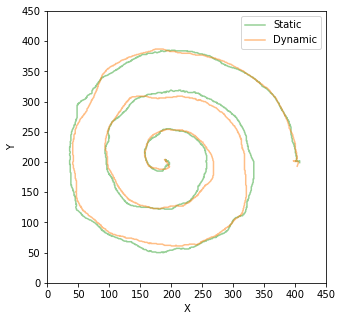

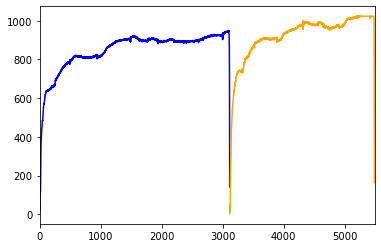

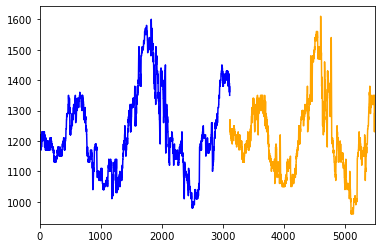

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  199  203  0         6       1810   16360374       0
1  199  203  0         6       1820   16360381       0
2  199  203  0         9       1820   16360388       0
3  199  202  0         9       1820   16360395       0
4  199  202  0         6       1810   16360402       0
file sequence: 12


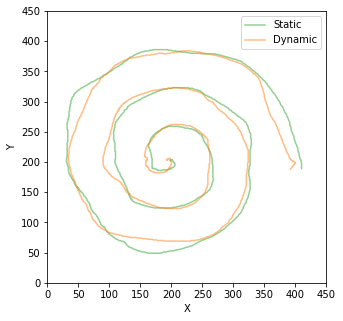

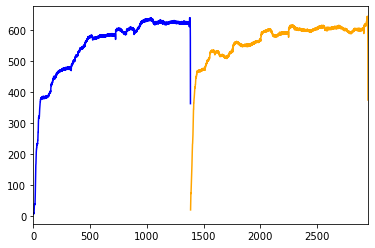

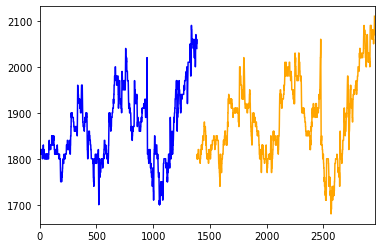

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  200  203  0         1       2050   16940821       0
1  200  203  0        14       2050   16940828       0
2  200  203  0        26       2040   16940835       0
3  200  203  0        38       2050   16940842       0
4  200  203  0        59       2040   16940849       0
file sequence: 13


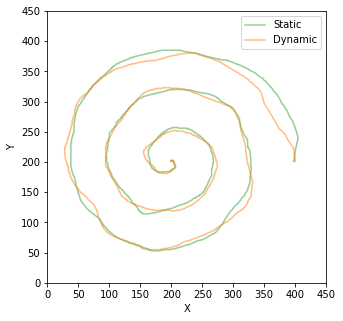

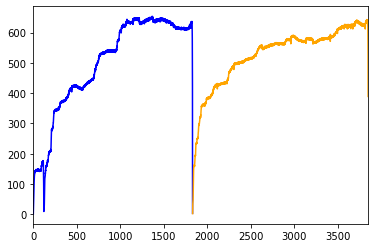

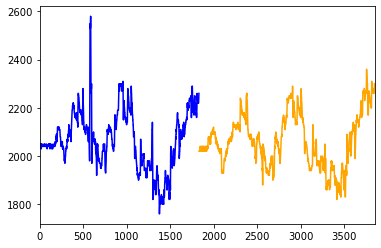

After reading file:       X    Y  Z  Pressure  GripAngle  Timestamp  TestID
0  191  205  0        39       1350   17535179       0
1  191  205  0        54       1360   17535186       0
2  191  205  0        60       1350   17535193       0
3  191  205  0        61       1360   17535200       0
4  191  205  0        64       1360   17535207       0
file sequence: 14


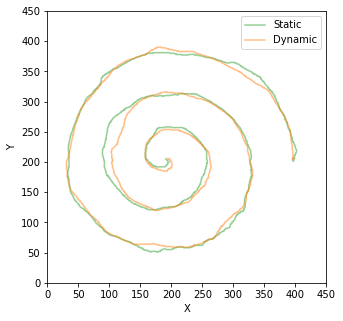

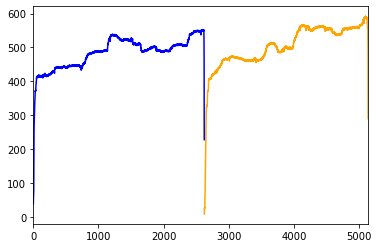

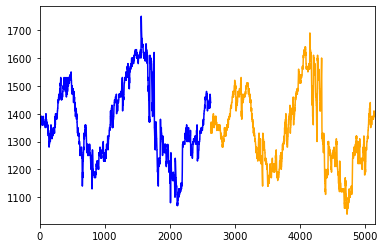

In [10]:
for i in range(len(control_file)): 
    (df,file)=read_file(control_file,i)
    print("file sequence:",i)
    get_plot(df)
    df_combined=get_combined(df) 
    df_combined=get_feature(df_combined)  
    data=get_mean_var(df_combined)
    save(data,file)